<a href="https://colab.research.google.com/github/aleluiz02/TransferLearning/blob/main/cats_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Transfer learning é uma técnica em aprendizado de máquina onde um modelo pré-treinado em um grande conjunto de dados (como o ImageNet, com milhões de imagens e milhares de classes) é reutilizado para uma tarefa específica, como classificar gatos e cachorros. Em vez de treinar um modelo do zero, usamos os pesos aprendidos do modelo pré-treinado, que já capturou características gerais (como bordas, texturas e formas) de imagens. Isso é especialmente útil quando:

* Temos um dataset pequeno, como o cats_vs_dogs.
* Queremos economizar tempo e recursos computacionais.
* Precisamos de um modelo com bom desempenho inicial.

No caso do código, usamos o MobileNetV2 pré-treinado no ImageNet, removendo a camada de classificação final e adicionando camadas específicas para classificar gatos e cachorros.

In [ ]:
# importação das bibliotecas
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

## Carregar o datasset cats_vs_dog

O dataset cats_vs_dogs está disponível no TensorFlow Datasets.

Dividimos o dataset em 80% para treino e 20% para teste

In [ ]:
# Carregar o dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names
print("Classes:", class_names)

Classes: ['cat', 'dog']


Redimensionamos as imagens para 224x224 (compatível com MobileNetV2) e normalizamos os valores dos pixels

In [ ]:
# Função para pré-processar as imagens
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Redimensionar para 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar para [0, 1]
    return image, label

# Aplicar pré-processamento
ds_train = ds_train.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

## MobileNetV2

Vamos usar o MobileNetV2 pré-treinado no ImageNet, mas sem a camada de classificação final

* ``weights='imagenet'``: Usa os pesos pré-treinados no ImageNet.
* ``include_top=False``: Exclui a camada densa final, já que vamos adicionar nossa própria camada para classificar gatos e cachorros.
* ``trainable=False``: Congela as camadas do modelo base para evitar que sejam atualizadas durante o treinamento inicial.

In [ ]:
# Carregar o modelo base MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

### Construir nosso modelo

Adicionamos camadas no topo do modelo base para classificar em duas categorias (gatos e cachorros)

* Usamos GlobalAveragePooling2D para reduzir a saída do modelo base.
* Uma camada densa com 128 neurônios e ativação ReLU é adicionada para aprendizado adicional.
* A camada final usa ativação sigmoid para classificação binária (0 para gatos, 1 para cachorros).
* binary_crossentropy é a função de perda adequada para classificação binária.

In [ ]:
# Adicionar camadas personalizadas
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Reduz a dimensionalidade
x = Dense(128, activation='relu')(x)  # Camada densa intermediária
outputs = Dense(1, activation='sigmoid')(x)  # Camada final para classificação binária
model = Model(inputs, outputs)

In [ ]:
# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Treinar o nosso modelo com as camadas congeladas

Primeiro, treinamos apenas as camadas personalizadas, mantendo o modelo base congelado

In [ ]:
# Treinar o modelo
history = model.fit(ds_train, epochs=1, validation_data=ds_test)

582/582 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.9841 - loss: 0.0462 - val_accuracy: 0.9839 - val_loss: 0.0448


### Fine-Tuning

Fine-tuning é o processo de ajustar (ou "afinar") um modelo pré-treinado para melhorar sua performance na tarefa específica. No transfer learning, inicialmente congelamos as camadas do modelo pré-treinado para usar seus pesos como estão, treinando apenas as novas camadas adicionadas. No fine-tuning:

* Descongelamos algumas (ou todas) as camadas do modelo base.
* Treinamos o modelo com uma taxa de aprendizado menor para ajustar os pesos de forma suave, preservando os padrões gerais aprendidos no ImageNet enquanto adaptamos o modelo ao dataset específico (gatos vs. cachorros).

Para melhorar a precisão, podemos descongelar algumas camadas do modelo base e realizar fine-tuning com uma taxa de aprendizado menor

* Descongelamos apenas as últimas 10 camadas do modelo base para ajustar os pesos levemente.
* Uma taxa de aprendizado menor (1e-5) evita mudanças drásticas nos pesos pré-treinados.

In [ ]:
# Descongelar algumas camadas do modelo base
base_model.trainable = True

# Congelar todas as camadas, exceto as últimas 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# Recompilar o modelo com uma taxa de aprendizado menor
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# resumo do modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 896,577 (3.42 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [ ]:
# Continuar o treinamento
history_fine = model.fit(ds_train, epochs=5, validation_data=ds_test)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 58s 79ms/step - accuracy: 0.9604 - loss: 0.1951 - val_accuracy: 0.9744 - val_loss: 0.1322
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 70s 68ms/step - accuracy: 0.9887 - loss: 0.0306 - val_accuracy: 0.9815 - val_loss: 0.0890
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.9937 - loss: 0.0174 - val_accuracy: 0.9850 - val_loss: 0.0714
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.9976 - loss: 0.0105 - val_accuracy: 0.9845 - val_loss: 0.0647
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - accuracy: 0.9989 - loss: 0.0068 - val_accuracy: 0.9854 - val_loss: 0.0632


### Avaliar o modelo

Avaliar o desempenho no conjunto de testes

In [ ]:
# Avaliar o modelo
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9842 - loss: 0.0408
Acurácia no conjunto de teste: 0.9839


### Visualizar os resultados

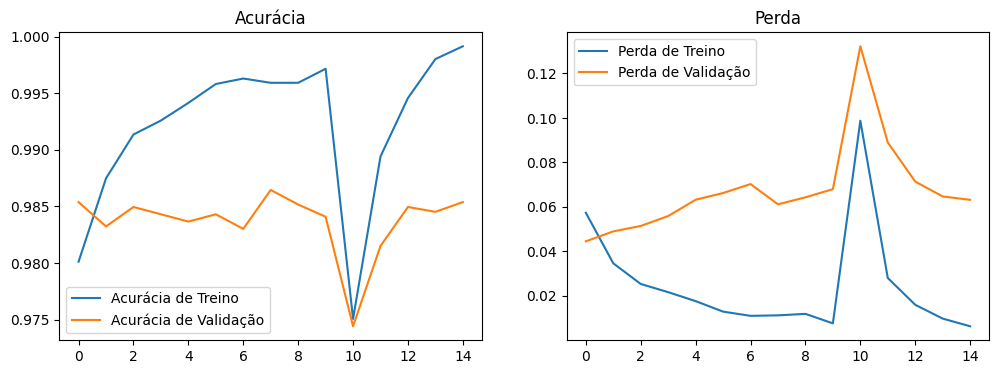

In [ ]:
# Plotar acurácia e perda
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.title('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.title('Perda')
plt.legend()
plt.show()

### Coletar previsões do modelo

Para criar a matriz de confusão, precisamos das previsões do modelo no conjunto de teste e os rótulos verdadeiros
* As previsões são binarizadas (0 para gatos, 1 para cachorros) com base no limiar 0.5, já que usamos ativação sigmoid na camada final.

In [ ]:
# Função para obter previsões e rótulos do conjunto de teste
def get_predictions_and_labels(model, dataset):
    y_true = []  # Rótulos verdadeiros
    y_pred = []  # Previsões do modelo

    for images, labels in dataset:
        predictions = model.predict(images)
        # Converter probabilidades em classes (0 ou 1) usando limiar 0.5
        predictions = (predictions > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(predictions)

    return np.array(y_true), np.array(y_pred)

# Obter previsões e rótulos do conjunto de teste
y_true, y_pred = get_predictions_and_labels(model, ds_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

### Matriz de confusão

A matriz de confusão mostra:
* Verdadeiro Negativo (TN): Gatos corretamente classificados como gatos (célula [0,0]).
* Falso Positivo (FP): Gatos incorretamente classificados como cachorros (célula [0,1]).
* Falso Negativo (FN): Cachorros incorretamente classificados como gatos (célula [1,0]).
* Verdadeiro Positivo (TP): Cachorros corretamente classificados como cachorros (célula [1,1]).

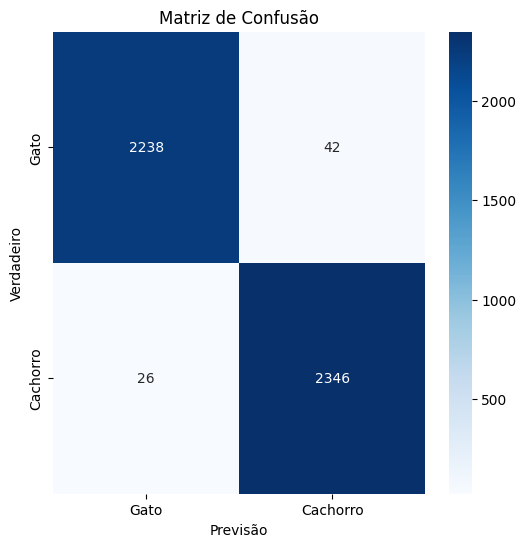

In [ ]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Visualizar a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Gato', 'Cachorro'],
            yticklabels=['Gato', 'Cachorro'])
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

### Calcular Precision, Recall e F1-score

* Precisão: Proporção de previsões positivas corretas (TP / (TP + FP)). Alta precisão significa poucas previsões incorretas (poucos falsos positivos).
* Recall: Proporção de positivos verdadeiros identificados (TP / (TP + FN)). Alto recall significa que a maioria foi corretamente identificada (poucos falsos negativos).
* F1-score: Média harmônica de precisão e recall (2 * (Precisão * Recall) / (Precisão + Recall)). Um bom F1-score indica um equilíbrio entre precisão e recall.

In [ ]:
# Calcular métricas
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Exibir resultados
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

print(classification_report(y_true, y_pred, target_names=class_names))

Precisão: 0.9824
Recall: 0.9890
F1-score: 0.9857
              precision    recall  f1-score   support

         cat       0.99      0.98      0.99      2280
         dog       0.98      0.99      0.99      2372

    accuracy                           0.99      4652
   macro avg       0.99      0.99      0.99      4652
weighted avg       0.99      0.99      0.99      4652



### Fazer previsões

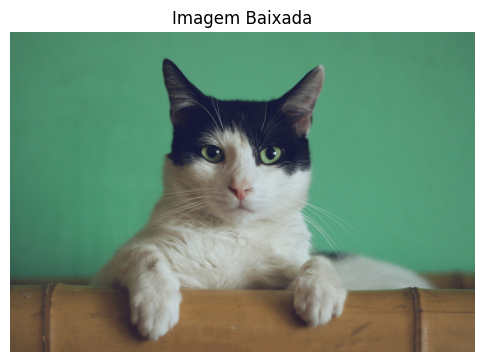

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Previsão: Gato (Probabilidade: 0.0000)


In [ ]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def display_and_predict_image_from_url(url, model):
    try:
        # Adicionar cabeçalho User-Agent para evitar bloqueios
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

        # Baixar a imagem
        response = requests.get(url, headers=headers, timeout=10)

        # Verificar se a requisição foi bem-sucedida
        if response.status_code != 200:
            raise ValueError(f"Erro ao baixar a imagem: Status {response.status_code}")

        # Verificar se o conteúdo é uma imagem válida
        content_type = response.headers.get('content-type', '')
        if 'image' not in content_type:
            raise ValueError(f"URL não aponta para uma imagem válida: {content_type}")

        # Tentar abrir a imagem
        img = Image.open(BytesIO(response.content)).convert('RGB')

        # Exibir a imagem
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Imagem Baixada')
        plt.show()

        # Pré-processar para previsão
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Fazer previsão
        prediction = model.predict(img_array)
        label = "Cachorro" if prediction[0] > 0.5 else "Gato"
        print(f'Previsão: {label} (Probabilidade: {prediction[0][0]:.4f})')

    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar a imagem: {e}")
    except ValueError as e:
        print(f"Erro: {e}")
    except Exception as e:
        print(f"Erro ao processar a imagem: {e}")

# Exemplo de uso
url = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba"
display_and_predict_image_from_url(url, model)

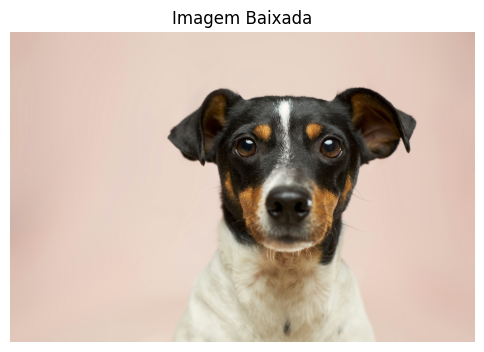

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Previsão: Cachorro (Probabilidade: 0.9999)


In [ ]:
url = "https://images.unsplash.com/photo-1561037404-61cd46aa615b"
display_and_predict_image_from_url(url, model)

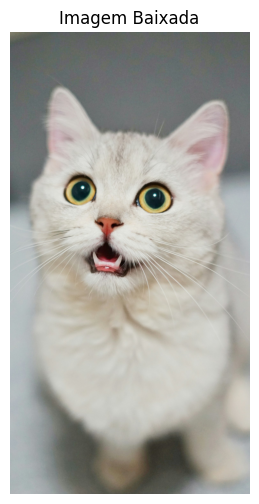

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Previsão: Gato (Probabilidade: 0.0000)


In [ ]:
url = "https://images.unsplash.com/photo-1561948955-570b270e7c36?q=80&w=1501&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
display_and_predict_image_from_url(url, model)

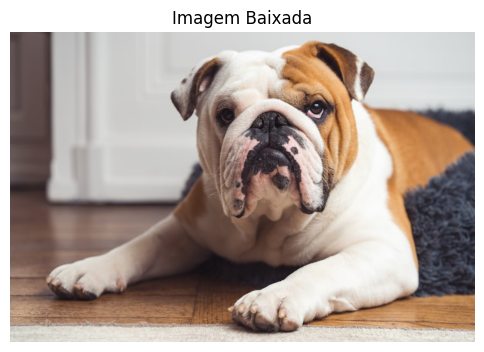

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Previsão: Cachorro (Probabilidade: 0.8958)


In [ ]:
url = "https://images.unsplash.com/photo-1648047116702-498bb37a5f64?q=80&w=871&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
display_and_predict_image_from_url(url, model)

### Aumentar os dados de treino

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Aplicar aumentação ao dataset de treino
def apply_augmentation(image, label):
    image = datagen.random_transform(image)
    return image, label

ds_train_aug = ds_train.map(apply_augmentation)

### Salvar modelo

In [ ]:
model.save('cats_vs_dogs_model.h5')